In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import weightstats as stests

conn = sqlite3.connect('poker_updated.db')
c = conn.cursor()

In [3]:
net_gains = pd.read_sql_query('SELECT player_ID, SUM(net_gain) AS total_net_gain FROM Hands \
GROUP BY player_ID;', conn)
print("rows: ", net_gains.shape[0])
print(net_gains.mean(axis = 0))

rows:  2397
total_net_gain   -6.085269
dtype: float64


In [4]:
total_games = pd.read_sql_query('SELECT player_ID, COUNT(*) AS total_games FROM Hands \
    GROUP BY player_ID;', conn)
summary = pd.merge(net_gains, total_games, on='player_ID')


In [5]:
hands = pd.read_sql_query('SELECT game_ID, player_ID, net_gain FROM Hands \
                          ORDER BY game_ID;', conn)
print(hands.shape[0])

291291


In [6]:
hands["appearence_id"] = hands.groupby("player_ID").cumcount()

In [12]:
avg_first_hand_net_gain = []
avg_last_hand_net_gain = []

#iterate through all players
for player_row in summary.itertuples():
    player_ID = player_row[1]
    player_hands = hands[hands['player_ID'] == player_ID]
    prev_hand_id = 0
    prev_hand_net_gain = None
    first_hand_net_gains = [] #net gains of all first hands
    last_hand_net_gains = [] #net gains of all last hands
    for hand_row in player_hands.itertuples():
        game_ID = int(hand_row[1])
        net_gain = int(hand_row[3])
        if game_ID - prev_hand_id > 50000: #longer than 500 seconds
            first_hand_net_gains.append(net_gain)
            if prev_hand_net_gain:
                last_hand_net_gains.append(prev_hand_net_gain)
        prev_hand_id = game_ID
        prev_hand_net_gain = net_gain
    
    avg_first_hand_net_gain.append(np.mean(first_hand_net_gains))
    if last_hand_net_gains:
        avg_last_hand_net_gain.append(np.mean(last_hand_net_gains))
    else:
        avg_last_hand_net_gain.append(net_gain)
    
summary['avg_first_hand_net_gain'] = avg_first_hand_net_gain
summary['avg_last_hand_net_gain'] = avg_last_hand_net_gain
summary['avg_net_gain'] = summary['total_net_gain']/summary['total_games']
print(summary.head(10))

          player_ID  total_net_gain  total_games  avg_first_hand_net_gain  \
0     !MushroomMan!           45.24           54                 0.000000   
1              ....            4.25           83                17.000000   
2             00MOD           -6.07           10                -3.000000   
3          01001111          -13.37           22                 0.000000   
4        0nlyDaNuts          126.79          260                -2.166667   
5  1000_na_nl25_aga          -96.95          305                 0.000000   
6          10071995           14.40           81                 0.000000   
7         100stacks          -31.34           50                -3.600000   
8        11-10-1964          -51.71           64                 0.000000   
9         12monkeys          -29.41          242                 0.000000   

   avg_last_hand_net_gain  avg_net_gain  
0                     0.0      0.837778  
1                     0.0      0.051205  
2                     0.0 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a254b1cf8>]],
      dtype=object)

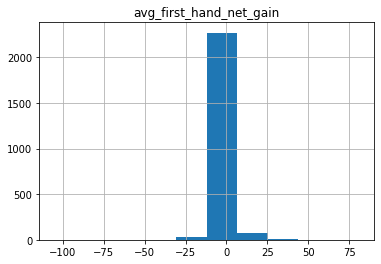

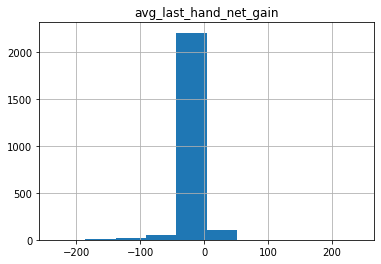

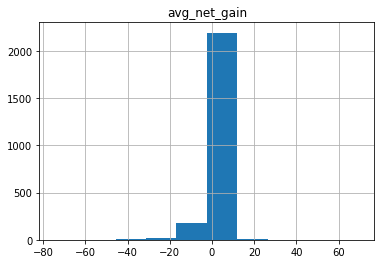

In [13]:
summary.hist('avg_first_hand_net_gain')
summary.hist('avg_last_hand_net_gain')
summary.hist('avg_net_gain')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a224124e0>]],
      dtype=object)

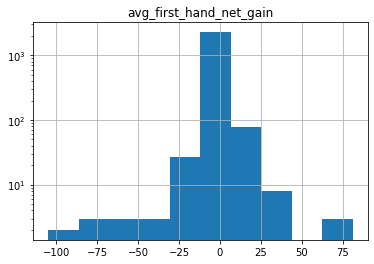

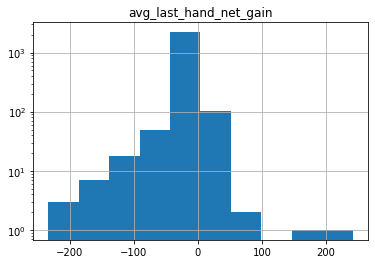

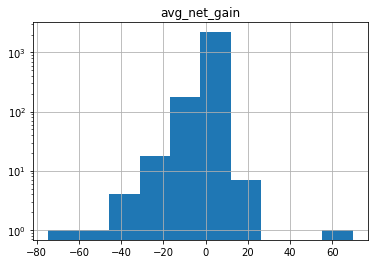

In [14]:
summary.hist('avg_first_hand_net_gain', log=True)
summary.hist('avg_last_hand_net_gain', log=True)
summary.hist('avg_net_gain', log=True)

In [16]:
tstat, pval = stests.ztest(summary['avg_last_hand_net_gain'], summary['avg_net_gain'])
print("p-value: ", pval)

p-value:  1.8833480166685e-17
